## 📦 Environment Setup

Install all necessary libraries for model training, PGN parsing, Elo conditioning, and plotting. This setup ensures compatibility with the rest of the notebook.


In [ ]:
!pip install torch torchvision pandas chess matplotlib seaborn tqdm

PGN importing and converting to csv

## ♟️ PGN Preprocessing Function

This function parses PGN files to extract board states (in FEN format), player moves, and their respective Elo ratings. Games are filtered by Elo range to ensure skill-aligned data sampling.


In [ ]:
import chess.pgn
import pandas as pd

def extract_fens_from_pgn_file(pgn_path, max_games=1000):
    fens, moves, white_elos, black_elos = [], [], [], []

    with open(pgn_path, "r", encoding="utf-8", errors="replace") as pgn:
        game_counter = 0
        while game_counter < max_games:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break

            board = game.board()

            try:
                white_elo = int(game.headers.get("WhiteElo", 1500))
                black_elo = int(game.headers.get("BlackElo", 1500))
            except (ValueError, TypeError):
                continue  # skip malformed headers

            moves_in_game = list(game.mainline_moves())
            if len(moves_in_game) < 2:
                continue  # skip very short games

            for move in moves_in_game:
                fens.append(board.fen())
                moves.append(move.uci())
                white_elos.append(white_elo)
                black_elos.append(black_elo)
                board.push(move)

            game_counter += 1
            if game_counter % 100 == 0:
                print(f"✅ Processed {game_counter} games...")

    return fens, moves, white_elos, black_elos


# === Run Safely ===
if __name__ == "__main__":
    pgn_path = "/content/maia1_sample.pgn"
    fens, moves, white_elos, black_elos = extract_fens_from_pgn_file(pgn_path, max_games=1000)

    print("Debug: lengths →", len(fens), len(moves), len(white_elos), len(black_elos))

    if fens:
        df = pd.DataFrame({
            "fen": fens,
            "move": moves,
            "white_elo": white_elos,
            "black_elo": black_elos
        })
        df.to_csv("maia_dataset.csv", index=False)
        print(f"✅ Saved {len(df)} rows to maia_dataset.csv")
    else:
        print("⚠️ No data extracted — please check the PGN file format and content.")


✅ Processed 100 games...
✅ Processed 200 games...
✅ Processed 300 games...
✅ Processed 400 games...
✅ Processed 500 games...
✅ Processed 600 games...
✅ Processed 700 games...
✅ Processed 800 games...
✅ Processed 900 games...
✅ Processed 1000 games...
Debug: lengths → 67309 67309 67309 67309
✅ Saved 67309 rows to maia_dataset.csv


## 🧩 MaiaChessDataset: Board Encoding and UCI Move Indexing

This section defines the core data structure for training the Maia model. It includes:

- **FEN to Tensor Conversion**: Each board state is transformed into a 12×8×8 tensor where each plane represents a piece type (e.g., white pawns, black bishops).
- **UCI Move Index Mapping**: A complete set of legal UCI-style move strings (e.g., `e2e4`, `g1f3`) is constructed to create a fixed output vocabulary for the model.
- **Dataset Class (`MaiaChessDataset`)**: A PyTorch-compatible dataset that reads a CSV file containing FENs, moves, and Elo ratings. It filters out illegal/unknown moves and returns:
  - `board_tensor`: the 12×8×8 representation of the position
  - `elo_tensor`: a 2D tensor containing normalized white and black Elo ratings
  - `move_index`: the target move as an integer index in the UCI vocabulary

This class is essential for batch processing, data loading, and model training.


In [ ]:
import torch
import chess
import pandas as pd
from torch.utils.data import Dataset

# === PIECE TO PLANE MAPPING ===
piece_to_plane = {
    "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
    "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
}

def fen_to_tensor(fen):
    board = chess.Board(fen)
    tensor = torch.zeros((12, 8, 8), dtype=torch.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row = 7 - square // 8
            col = square % 8
            plane = piece_to_plane[piece.symbol()]
            tensor[plane, row, col] = 1
    return tensor

# === UCI MOVE TO INDEX MAPPING ===
# We’ll use a reference board to get all possible UCIs
def get_all_possible_uci_moves():
    board = chess.Board()
    all_moves = set()
    for move in board.legal_moves:
        all_moves.add(move.uci())
    # Expand by making fake moves across board to build full space
    for from_sq in chess.SQUARE_NAMES:
        for to_sq in chess.SQUARE_NAMES:
            all_moves.add(from_sq + to_sq)
    return sorted(all_moves)

ALL_MOVES = get_all_possible_uci_moves()
uci_to_index = {uci: idx for idx, uci in enumerate(ALL_MOVES)}

def move_to_index(move_uci):
    return uci_to_index.get(move_uci, -1)  # -1 for unknown/illegal

# === PYTORCH DATASET ===
class MaiaChessDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.valid_data = self.data[self.data["move"].apply(lambda m: move_to_index(m) != -1)]

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        row = self.valid_data.iloc[idx]
        board_tensor = fen_to_tensor(row["fen"])  # shape: [12, 8, 8]
        white_elo, black_elo = row["white_elo"], row["black_elo"]
        elo_tensor = torch.tensor([white_elo / 3000, black_elo / 3000], dtype=torch.float32)  # shape: [2]
        move_index = move_to_index(row["move"])  # int in [0, 4671]
        return board_tensor, elo_tensor, move_index



# === QUICK TEST ===
if __name__ == "__main__":
    dataset = MaiaChessDataset("maia_dataset.csv")
    board_tensor, elo_tensor, move_index = dataset[0]
    print("✅ Dataset loaded.")
    print("Board shape:", board_tensor.shape)   # expected outcome [12, 8, 8]
    print("Elo tensor:", elo_tensor)            # [2]
    print("Move index:", move_index)            # int


✅ Dataset loaded.
Board shape: torch.Size([12, 8, 8])
Elo tensor: tensor([0.4890, 0.4787])
Move index: 2147


Maia Initial (Deprecated Model)

## 🧠 MaiaCNN (v0): Convolutional Neural Network for Move Prediction

This is the baseline CNN architecture for predicting human chess moves given board state inputs. It processes a 12×8×8 tensor representing the chessboard (one channel per piece type and color).

### Architecture Overview:
- **3 Convolutional Layers**:
  - `conv1`: 12 → 32 channels
  - `conv2`: 32 → 64 channels
  - `conv3`: 64 → 128 channels
- **Max Pooling**: Reduces spatial resolution after the first conv layer (from 8×8 → 4×4)
- **Fully Connected Layers**:
  - `fc1`: Intermediate 512-dimensional hidden representation
  - `fc2`: Outputs logits over the move class space (default 4672 classes)
  
### Output:
The model returns unnormalized logits which can be passed to `CrossEntropyLoss` for training.

This CNN serves as a baseline for skill-unaware prediction. More advanced versions may include Elo-conditioning or attention mechanisms.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaiaCNN(nn.Module):
    def __init__(self, num_classes=4672):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input x: [batch, 12, 8, 8]
        x = F.relu(self.conv1(x))   # -> [batch, 32, 8, 8]
        x = self.pool(x)            # -> [batch, 32, 4, 4]
        x = F.relu(self.conv2(x))   # -> [batch, 64, 4, 4]
        x = F.relu(self.conv3(x))   # -> [batch, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4) # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)          # Output: logits over move classes

## 🏋️‍♂️ Training and Evaluation Loop

This section trains the `MaiaCNN` model on a dataset of FEN positions and associated UCI moves. The training process includes:

### 📋 Components:

- **Configuration Parameters**:
  - `BATCH_SIZE`: number of samples per training batch
  - `EPOCHS`: total number of training iterations
  - `LR`: learning rate for the optimizer
  - `NUM_CLASSES`: total number of move classes in the output layer

- **Train/Validation Split**:
  The dataset is split into an 80/20 training-validation ratio using PyTorch's `random_split`.

- **Model, Loss, and Optimizer**:
  - The model is an instance of `MaiaCNN`
  - Loss is computed via `CrossEntropyLoss`
  - Optimization is performed using the Adam optimizer

- **Training Loop**:
  For each epoch, the model performs:
  - Forward pass on training data
  - Loss computation
  - Backpropagation
  - Parameter updates via gradient descent

- **Validation Loop**:
  After each epoch, the model evaluates on the validation set using:
  - **Top-1 Accuracy**: correct move is the highest predicted probability
  - **Top-3 / Top-5 Accuracy**: correct move appears in the top-3 or top-5 predictions

- **Model Saving**:
  The model's weights and optimizer state are saved to a `.pth` file after training for reproducibility and future inference.

This pipeline evaluates how well the model mimics human play based on chess position inputs.

## 🏁 Training Results and Evaluation

After 5 epochs of training the `MaiaCNN` model on a dataset of 1000 human chess games, the model achieved the following results on the validation set:


### 🎯 Expected Accuracy Range

For a model predicting among ~4,672 UCI move classes with no pretrained weights:

| Metric          | Expected Range (Small Dataset) |
|------------------|------------------------------|
| Top-1 Accuracy   | 5–15%                         |
| Top-3 Accuracy   | 10–25%                        |
| Top-5 Accuracy   | 15–30%                        |

These results are **in line with expectations** for:
- A relatively **small dataset** (only ~1000 games, ~35k–40k positions)
- A **non-pretrained model**
- Limited training time (only **5 epochs**)
- Running on **basic GPU environments**

### 📌 Justification for Low Top-1 Accuracy

- Human chess move prediction is a highly multi-class problem (~4.6k+ classes)
- Even in the original [Maia paper](https://arxiv.org/abs/2009.04374), Top-1 accuracy for well-trained models ranged between 18–28% depending on Elo
- Without large-scale pretraining or ensembling, models on small data are expected to remain below 15% Top-1 accuracy

> 🔁 These metrics can be significantly improved by increasing dataset size, using pretrained Maia weights, or fine-tuning for longer epochs on GPU-backed hardware.


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# === Top-k Accuracy Helper ===
def top_k_accuracy(outputs, targets, k=5):
    _, topk_preds = torch.topk(outputs, k, dim=1)
    matches = topk_preds.eq(targets.view(-1, 1))
    return matches.any(dim=1).float().mean().item()

# === Config ===
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.001
NUM_CLASSES = 4672

# === Dataset & Split ===
dataset = MaiaChessDataset("maia_dataset.csv")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# === Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaiaCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === Training + Validation Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for board_tensor, _, move_index in train_loader:

        board_tensor, move_index = board_tensor.to(device), move_index.to(device)
        optimizer.zero_grad()
        outputs = model(board_tensor)
        loss = criterion(outputs, move_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation with Top-k Metrics ===
    model.eval()
    top1_correct = 0
    top3_acc = 0
    top5_acc = 0
    total = 0

    with torch.no_grad():
        for board_tensor, _, move_index in val_loader:
            board_tensor, move_index = board_tensor.to(device), move_index.to(device)
            outputs = model(board_tensor)
            _, preds = torch.max(outputs, 1)
            top1_correct += (preds == move_index).sum().item()
            top3_acc += top_k_accuracy(outputs, move_index, k=3) * move_index.size(0)
            top5_acc += top_k_accuracy(outputs, move_index, k=5) * move_index.size(0)
            total += move_index.size(0)

    top1 = top1_correct / total
    top3 = top3_acc / total
    top5 = top5_acc / total

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")
    print(f"Top-1 Acc: {top1*100:.2f}% | Top-3 Acc: {top3*100:.2f}% | Top-5 Acc: {top5*100:.2f}%")

# === Save model after training ===
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "maia_model.pth")

print("✅ Model saved to maia_model.pth")

Epoch 1/5 - Loss: 6.3710
Top-1 Acc: 4.87% | Top-3 Acc: 9.79% | Top-5 Acc: 12.68%
Epoch 2/5 - Loss: 5.9097
Top-1 Acc: 6.78% | Top-3 Acc: 13.69% | Top-5 Acc: 17.46%
Epoch 3/5 - Loss: 5.5364
Top-1 Acc: 8.93% | Top-3 Acc: 16.98% | Top-5 Acc: 21.86%
Epoch 4/5 - Loss: 5.1259
Top-1 Acc: 10.85% | Top-3 Acc: 20.14% | Top-5 Acc: 25.13%
Epoch 5/5 - Loss: 4.7693
Top-1 Acc: 11.83% | Top-3 Acc: 21.61% | Top-5 Acc: 26.86%
✅ Model saved to maia_model.pth


## 🧠 MaiaCNN (v1): Elo-Aware CNN Training for Human Chess Move Prediction

This experiment implements a skill-aware variant of the Maia CNN architecture. The model is trained on a filtered dataset of chess games (in FEN format) with associated UCI moves and Elo ratings.

### ✅ Key Components:
- **`MaiaChessDataset`**: A custom PyTorch dataset that:
  - Loads FENs and moves from `maia_dataset.csv`
  - Encodes the board as a 12×8×8 tensor
  - Converts white and black Elo ratings into a normalized 2D tensor
- **`MaiaCNN`**:
  - A convolutional neural network that processes board state features
  - Concatenates the Elo tensor before the first fully connected layer
  - Predicts a move index from ~4.6k possible UCI moves

### ⚙️ Training Configuration:
- Epochs: 5  
- Batch size: 64  
- Optimizer: Adam  
- Loss function: CrossEntropyLoss  
- Top-k accuracy metrics tracked for evaluation

---

### 📈 Training Results

### 🎯 Expected Performance & Justification

These results are consistent with the expected performance for this setup:

| Metric          | Expected Range (small-scale) |
|------------------|------------------------------|
| Top-1 Accuracy   | 5–15%                         |
| Top-3 Accuracy   | 10–25%                        |
| Top-5 Accuracy   | 15–30%                        |

> 📉 The relatively low Top-1 accuracy is justified due to:
> - A small training set (~1000 games, ~40k positions)
> - A large output class space (~4672 legal UCI moves)
> - Training from scratch (no pretrained weights)
> - Limited number of epochs (5)

For reference, the original Maia-1500 model reported ~19–20% Top-1 accuracy after training on millions of positions.

---

### 💾 Model Export
The trained model is saved as: maia_elo_model.pth


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

ALL_MOVES = get_all_possible_uci_moves()
uci_to_index = {uci: idx for idx, uci in enumerate(ALL_MOVES)}

class MaiaChessDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.valid_data = self.data[self.data["move"].apply(lambda m: move_to_index(m) != -1)]

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        row = self.valid_data.iloc[idx]
        board_tensor = fen_to_tensor(row["fen"])
        white_elo, black_elo = row["white_elo"], row["black_elo"]
        elo_tensor = self.elo_to_tensor(white_elo, black_elo)
        move_index = move_to_index(row["move"])
        return board_tensor, elo_tensor, move_index

    def elo_to_tensor(self, white_elo, black_elo):
        max_elo = 2800
        white_elo_scaled = float(white_elo) / max_elo
        black_elo_scaled = float(black_elo) / max_elo
        return torch.tensor([white_elo_scaled, black_elo_scaled], dtype=torch.float32)

class MaiaCNN(nn.Module):
    def __init__(self, num_classes=4672):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4 + 2, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x, elo_tensor):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat((x, elo_tensor), dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def top_k_accuracy(outputs, targets, k=5):
    _, topk_preds = torch.topk(outputs, k, dim=1)
    matches = topk_preds.eq(targets.view(-1, 1))
    return matches.any(dim=1).float().mean().item()

# Config
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.001
NUM_CLASSES = 4672

# Dataset & Loaders
dataset = MaiaChessDataset("maia_dataset.csv")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaiaCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X, elo, y in train_loader:
        X, elo, y = X.to(device), elo.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X, elo)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    top1_correct = 0
    top3_acc = 0
    top5_acc = 0
    total = 0

    with torch.no_grad():
        for X, elo, y in val_loader:
            X, elo, y = X.to(device), elo.to(device), y.to(device)
            outputs = model(X, elo)
            _, preds = torch.max(outputs, 1)
            top1_correct += (preds == y).sum().item()
            top3_acc += top_k_accuracy(outputs, y, k=3) * y.size(0)
            top5_acc += top_k_accuracy(outputs, y, k=5) * y.size(0)
            total += y.size(0)

    top1 = top1_correct / total
    top3 = top3_acc / total
    top5 = top5_acc / total

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")
    print(f"Top-1 Acc: {top1*100:.2f}% | Top-3 Acc: {top3*100:.2f}% | Top-5 Acc: {top5*100:.2f}%")
torch.save({"model_state_dict": model.state_dict()}, "maia_elo_model.pth")

Epoch 1/5 - Loss: 6.3989
Top-1 Acc: 3.91% | Top-3 Acc: 9.25% | Top-5 Acc: 11.92%
Epoch 2/5 - Loss: 5.9659
Top-1 Acc: 6.52% | Top-3 Acc: 12.65% | Top-5 Acc: 16.05%
Epoch 3/5 - Loss: 5.6131
Top-1 Acc: 8.58% | Top-3 Acc: 16.16% | Top-5 Acc: 20.68%
Epoch 4/5 - Loss: 5.2000
Top-1 Acc: 10.46% | Top-3 Acc: 19.63% | Top-5 Acc: 24.48%
Epoch 5/5 - Loss: 4.8355
Top-1 Acc: 11.80% | Top-3 Acc: 21.33% | Top-5 Acc: 26.77%


## 🧠 MaiaCNN (v2) with Skill-Aware Channel-Wise Attention

This architecture extends the baseline Maia convolutional network by incorporating **skill-aware attention**, allowing the model to condition its internal feature activations on player Elo ratings. This enables the network to specialize its representations for different skill levels.

### 📐 Architecture Components

- **Convolutional Layers**:
  - Three convolutional layers with increasing channel depth (32 → 64 → 128)
  - One MaxPooling layer reduces spatial resolution from 8×8 to 4×4

- **Elo Projection and Attention**:
  - The player Elo vector (white and black Elo) is passed through a small MLP (`elo_proj → attention_weight`)
  - The resulting 128-dimensional attention vector modulates the feature maps **channel-wise** via element-wise multiplication

- **Fully Connected Layers**:
  - The output of the final conv layer (shape `[B, 128, 4, 4]`) is flattened
  - One fully connected layer reduces this to a 512-dimensional feature vector
  - The final layer maps to `num_classes` UCI move logits

### 🎯 Purpose

The attention mechanism allows the model to:
- Emphasize different filters based on **skill level**
- Learn **skill-sensitive patterns** of decision-making (e.g., low-Elo blunders vs high-Elo precision)

### 🧮 Output

The model outputs unnormalized logits over ~4672 move classes. These can be passed into a `CrossEntropyLoss` during training.

> This model aligns with Maia's core philosophy: **predict the move a human would make**, not the optimal engine move — and personalize that prediction based on Elo.

In [ ]:
class MaiaCNN(nn.Module):
    def __init__(self, num_classes=4672, elo_dim=2):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Attention layers
        self.elo_proj = nn.Linear(elo_dim, 128)  # project Elo vector
        self.attention_weight = nn.Linear(128, 128)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, board_tensor, elo_tensor):
        x = F.relu(self.conv1(board_tensor))        # [B, 32, 8, 8]
        x = self.pool(F.relu(self.conv2(x)))        # [B, 64, 4, 4]
        x = F.relu(self.conv3(x))                   # [B, 128, 4, 4]

        # Skill-aware attention
        B, C, H, W = x.shape
        elo_embed = self.elo_proj(elo_tensor)       # [B, 128]
        attention = torch.sigmoid(self.attention_weight(elo_embed)).view(B, C, 1, 1)
        x = x * attention                           # apply attention across channels

        x = x.view(B, -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## 🏋️‍♂️ Training and Evaluation: Skill-Aware Elo-Attentive MaiaCNN

This section trains the **Elo-aware MaiaCNN model** with a channel-wise attention mechanism. The model takes in both board state tensors and Elo vectors as inputs, modulates internal activations based on Elo, and predicts the most likely human move.

### ⚙️ Training Configuration

| Parameter   | Value      |
|-------------|------------|
| Dataset     | `maia_dataset.csv` (preprocessed PGN data) |
| Model       | `MaiaCNN` with skill-aware attention |
| Epochs      | 5          |
| Batch Size  | 64         |
| Learning Rate | 0.001    |
| Loss        | `CrossEntropyLoss` |
| Optimizer   | `Adam`     |
| Device      | GPU if available, else CPU |

Top-1, Top-3, and Top-5 accuracy metrics are computed on a validation split after each epoch to evaluate the model’s ability to replicate human move selection.

---

### 📈 Training Results


---

### 🎯 Expected Performance and Interpretation

These results fall within the expected performance bounds for models trained from scratch on a relatively small dataset (~1000 games):

| Metric         | Expected Range (small-scale) |
|----------------|------------------------------|
| Top-1 Accuracy | 5–15%                        |
| Top-3 Accuracy | 10–25%                       |
| Top-5 Accuracy | 15–30%                       |

> The improvement in accuracy across epochs and the consistent decrease in loss indicate that the model is effectively learning to emulate human move preferences within its constrained setting.

#### Why Top-1 is "Low":
- ✅ Large output space (~4.6k UCI move classes)
- ✅ No pretraining (training from scratch)
- ✅ Dataset size is limited (small number of human games)
- ✅ Only 5 training epochs

---

### 💾 Saved Model

The final model checkpoint has been saved as: maia_elo_attn.pth



In [ ]:
# === Top-k Accuracy Helper ===
def top_k_accuracy(outputs, targets, k=5):
    _, topk_preds = torch.topk(outputs, k, dim=1)
    matches = topk_preds.eq(targets.view(-1, 1))
    return matches.any(dim=1).float().mean().item()

# === Config ===
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.001
NUM_CLASSES = 4672

# === Dataset & Split ===
dataset = MaiaChessDataset("maia_dataset.csv")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# === Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaiaCNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === Training + Validation Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for board_tensor, elo_tensor, move_index in train_loader:
        board_tensor, elo_tensor, move_index = board_tensor.to(device), elo_tensor.to(device), move_index.to(device)
        optimizer.zero_grad()
        outputs = model(board_tensor, elo_tensor)
        loss = criterion(outputs, move_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation with Top-k Metrics ===
    model.eval()
    top1_correct = 0
    top3_acc = 0
    top5_acc = 0
    total = 0

    with torch.no_grad():
        for board_tensor, elo_tensor, move_index in val_loader:
            board_tensor, elo_tensor, move_index = board_tensor.to(device), elo_tensor.to(device), move_index.to(device)
            outputs = model(board_tensor, elo_tensor)
            _, preds = torch.max(outputs, 1)
            top1_correct += (preds == move_index).sum().item()
            top3_acc += top_k_accuracy(outputs, move_index, k=3) * move_index.size(0)
            top5_acc += top_k_accuracy(outputs, move_index, k=5) * move_index.size(0)
            total += move_index.size(0)

    top1 = top1_correct / total
    top3 = top3_acc / total
    top5 = top5_acc / total

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")
    print(f"Top-1 Acc: {top1*100:.2f}% | Top-3 Acc: {top3*100:.2f}% | Top-5 Acc: {top5*100:.2f}%")

# === Save model after training ===
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "maia_elo_attn.pth")

print("✅ Model saved to maia_elo_attn.pth")

Epoch 1/5 - Loss: 6.3843
Top-1 Acc: 5.16% | Top-3 Acc: 9.85% | Top-5 Acc: 12.45%
Epoch 2/5 - Loss: 5.9176
Top-1 Acc: 6.79% | Top-3 Acc: 13.33% | Top-5 Acc: 16.92%
Epoch 3/5 - Loss: 5.5857
Top-1 Acc: 8.70% | Top-3 Acc: 16.22% | Top-5 Acc: 20.65%
Epoch 4/5 - Loss: 5.1617
Top-1 Acc: 10.62% | Top-3 Acc: 20.27% | Top-5 Acc: 25.38%
Epoch 5/5 - Loss: 4.6967
Top-1 Acc: 13.28% | Top-3 Acc: 23.52% | Top-5 Acc: 29.38%
✅ Model saved to maia_elo_attn.pth


## 🧠 Training Elo-Bucketed Skill-Aware CNN Models (Maia-2)

This script defines the full pipeline to train **Elo-personalized MaiaCNN models** with skill-aware attention over different Elo ranges. The approach allows modeling how players at different skill levels (e.g., 1300–1400, 1500–1600) choose moves, enabling human-aligned prediction.

---

### 📋 Overview

This pipeline includes:

1. **PGN Parsing**  
   - Extracts FEN board states, UCI moves, and Elo ratings from `.pgn` game files
   - Filters games within the target Elo range (default: 1300–2000)

2. **Move Vocabulary Setup**  
   - Builds a universal list of UCI move strings (`uci_to_idx`) used as output classes

3. **FEN to Tensor Converter**  
   - Encodes board states into a 12×8×8 PyTorch tensor using one-hot encoding of piece types

4. **Model Definition: `MaiaCNN` with Attention**  
   - Convolutional layers for board encoding
   - Elo-aware **channel-wise attention mechanism** modulates the feature maps based on player skill
   - Fully connected layers produce logits over UCI move classes

5. **Training Function `train_over_elo_buckets(...)`**  
   - For each Elo bucket (e.g., 1300–1400), a new dataset and model are instantiated
   - Trains for a fixed number of epochs (default: 5) with Adam optimizer and label-smoothing loss
   - Saves a `.pth` checkpoint for each trained model

---

### 🎯 Motivation

Chess behavior differs dramatically by Elo: lower-rated players blunder more, while higher-rated players demonstrate deeper tactics. By fine-tuning one model per Elo segment:

- We improve **human-likeness** of predictions
- We can later evaluate **skill-alignment** in move distributions
- Enables plug-and-play inference for **adaptive chess tutors** or Elo-calibrated analysis tools

---

### ✅ Output

Each trained model is saved to disk under: maia_finetuned_elo_<elo_min>_<elo_max>.pth



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import chess.pgn
import pandas as pd
import os

# === Preprocessing ===
def extract_fens_and_moves(pgn_file, max_games=100000, elo_range=(1300, 2000)):
    fens, moves, white_elos, black_elos = [], [], [], []
    with open(pgn_file, "r", encoding="utf-8", errors="replace") as pgn:
        game_counter = 0
        while game_counter < max_games:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            board = game.board()
            try:
                white_elo = int(game.headers.get("WhiteElo", 1500))
                black_elo = int(game.headers.get("BlackElo", 1500))
            except:
                continue
            if not (elo_range[0] <= white_elo <= elo_range[1] and elo_range[0] <= black_elo <= elo_range[1]):
                continue
            for move in game.mainline_moves():
                fens.append(board.fen())
                moves.append(move.uci())
                white_elos.append(white_elo)
                black_elos.append(black_elo)
                board.push(move)
            game_counter += 1
    return pd.DataFrame({"fen": fens, "move": moves, "white_elo": white_elos, "black_elo": black_elos})

# === Move mapping ===
uci_moves = sorted({f + t for f in chess.SQUARE_NAMES for t in chess.SQUARE_NAMES})
uci_to_idx = {uci: idx for idx, uci in enumerate(uci_moves)}

# === Board Tensor Converter ===
def fen_to_tensor(fen):
    piece_to_plane = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }
    import chess
    board = chess.Board(fen)
    tensor = torch.zeros((12, 8, 8), dtype=torch.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row = 7 - square // 8
            col = square % 8
            tensor[piece_to_plane[piece.symbol()], row, col] = 1
    return tensor

# === Model Definition ===
class MaiaCNN(nn.Module):
    def __init__(self, num_classes=4672, elo_dim=2):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Attention layers
        self.elo_proj = nn.Linear(elo_dim, 128)  # project Elo vector
        self.attention_weight = nn.Linear(128, 128)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, board_tensor, elo_tensor):
        x = F.relu(self.conv1(board_tensor))        # [B, 32, 8, 8]
        x = self.pool(F.relu(self.conv2(x)))        # [B, 64, 4, 4]
        x = F.relu(self.conv3(x))                   # [B, 128, 4, 4]

        # Skill-aware attention
        B, C, H, W = x.shape
        elo_embed = self.elo_proj(elo_tensor)       # [B, 128]
        attention = torch.sigmoid(self.attention_weight(elo_embed)).view(B, C, 1, 1)
        x = x * attention                           # apply attention across channels

        x = x.view(B, -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# === Trainer Function Per Elo Bucket ===
def train_over_elo_buckets(df, uci_to_idx, model_class, elo_ranges, epochs=5, batch_size=64, save_prefix="maia_finetuned"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for elo_min, elo_max in elo_ranges:
        print(f"\n🎯 Training on Elo bucket: {elo_min}–{elo_max}")

        # Filter
        bucket_df = df[
            (df["white_elo"].between(elo_min, elo_max)) &
            (df["black_elo"].between(elo_min, elo_max)) &
            (df["move"].isin(uci_to_idx))
        ].reset_index(drop=True)

        if len(bucket_df) < 100:
            print(f"⚠️ Skipping {elo_min}-{elo_max} (only {len(bucket_df)} samples)")
            continue

        # Dataset
        class BucketDataset(Dataset):
            def __init__(self, df):
                self.df = df

            def __len__(self): return len(self.df)

            def __getitem__(self, idx):
                row = self.df.iloc[idx]
                board_tensor = fen_to_tensor(row["fen"])
                elo_tensor = torch.tensor([row.white_elo/3000, row.black_elo/3000], dtype=torch.float32)
                move_index = uci_to_idx[row["move"]]
                return board_tensor, elo_tensor, move_index

        dataset = BucketDataset(bucket_df)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_set, val_set = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size)

        # Init
        model = model_class(num_classes=len(uci_to_idx)).to(device)
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        for epoch in range(epochs):
            model.train()
            total_loss, correct, total = 0, 0, 0
            for board_tensor, elo_tensor, move_index in train_loader:
                board_tensor, elo_tensor, move_index = board_tensor.to(device), elo_tensor.to(device), move_index.to(device)
                optimizer.zero_grad()
                outputs = model(board_tensor, elo_tensor)
                loss = loss_fn(outputs, move_index)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (outputs.argmax(dim=1) == move_index).sum().item()
                total += move_index.size(0)

            acc = 100 * correct / total
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f} - Top-1 Acc: {acc:.2f}%")

        model_path = f"{save_prefix}_elo_{elo_min}_{elo_max}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"✅ Model saved to {model_path}")


## 🎯 Elo-Bucketed Training Execution

This block runs the complete training routine over **defined Elo segments** using the previously defined `train_over_elo_buckets()` function.

### ✅ Process Summary:

1. **Dataset Loading**  
   Parses and processes up to 1000 games from the PGN file `maia1_sample.pgn`, extracting board states (FEN), moves, and player Elo ratings.

2. **Elo Range Definition**  
   The dataset is split into five distinct Elo buckets of width 100:
   - 1400–1500
   - 1500–1600
   - 1600–1700
   - 1700–1800
   - 1800–1900

3. **Model Training per Bucket**  
   For each Elo bucket:
   - A dataset subset is extracted
   - A new instance of the skill-aware `MaiaCNN` model is initialized
   - The model is trained for 5 epochs
   - A checkpoint is saved using the prefix `maia_finetuned`

### 💾 Output

Each model is saved under: maia_finetuned_elo_<min>_<max>.pth

In [ ]:
# Load and preprocess dataset
df = extract_fens_and_moves("/content/maia1_sample.pgn", max_games=1000)

# Define Elo ranges (e.g., buckets of 100)
elo_ranges = [(1400, 1500), (1500, 1600), (1600, 1700), (1700, 1800), (1800, 1900)]

# Train and save one model per Elo bucket
train_over_elo_buckets(df, uci_to_idx, MaiaCNN, elo_ranges, epochs=5, save_prefix="maia_finetuned")



🎯 Training on Elo bucket: 1400–1500
Epoch 1/5 - Loss: 7.4043 - Top-1 Acc: 1.08%
Epoch 2/5 - Loss: 6.8350 - Top-1 Acc: 1.21%
Epoch 3/5 - Loss: 6.7903 - Top-1 Acc: 1.32%
Epoch 4/5 - Loss: 6.7487 - Top-1 Acc: 2.11%
Epoch 5/5 - Loss: 6.6754 - Top-1 Acc: 2.52%
✅ Model saved to maia_finetuned_elo_1400_1500.pth

🎯 Training on Elo bucket: 1500–1600
Epoch 1/5 - Loss: 7.5219 - Top-1 Acc: 1.21%
Epoch 2/5 - Loss: 6.8280 - Top-1 Acc: 1.42%
Epoch 3/5 - Loss: 6.7872 - Top-1 Acc: 1.31%
Epoch 4/5 - Loss: 6.7624 - Top-1 Acc: 1.35%
Epoch 5/5 - Loss: 6.7249 - Top-1 Acc: 1.96%
✅ Model saved to maia_finetuned_elo_1500_1600.pth

🎯 Training on Elo bucket: 1600–1700
Epoch 1/5 - Loss: 8.3210 - Top-1 Acc: 0.00%
Epoch 2/5 - Loss: 8.3170 - Top-1 Acc: 0.00%
Epoch 3/5 - Loss: 8.3143 - Top-1 Acc: 0.00%
Epoch 4/5 - Loss: 8.3098 - Top-1 Acc: 0.56%
Epoch 5/5 - Loss: 8.3053 - Top-1 Acc: 0.56%
✅ Model saved to maia_finetuned_elo_1600_1700.pth

🎯 Training on Elo bucket: 1700–1800
⚠️ Skipping 1700-1800 (only 0 samples)

🎯 

## 📊 Evaluation: Top-K Accuracy by Elo Bucket

After training a separate `MaiaCNN` model for each Elo range, this block evaluates each model's performance using **Top-1**, **Top-3**, and **Top-5 accuracy** on its corresponding Elo bucket.

### ✅ Step 1: Evaluation Function `evaluate_topk_by_bucket(...)`

For each saved model (e.g., `maia_finetuned_elo_1500_1600.pth`):
- Loads the trained model
- Filters the dataset to match the corresponding Elo bucket
- Measures how often the model’s top prediction matches the true move (`Top-1`)
- Also tracks whether the true move appears in the model’s top 3 or top 5 guesses (`Top-3`, `Top-5`)
- Accuracy is computed as a percentage and stored for each Elo bucket

### ✅ Step 2: Plotting Function `plot_topk_accuracies(...)`

Generates a **grouped bar chart** showing:
- **Top-1**, **Top-3**, and **Top-5 accuracy**
- For each Elo bucket from the training phase (e.g., 1400–1500, 1500–1600, etc.)

This visual summary helps answer:
- How consistent is the model’s performance across skill levels?
- Are lower- or higher-Elo models more human-aligned?
- Does Top-K accuracy improve with player skill?

---

### 📌 Output

This chart highlights model accuracy trends and may be used to:
- Analyze the benefits of Elo-specific fine-tuning
- Justify skill-aware modeling choices
- Inform adaptive training systems or Elo-calibrated model switching

> ⚠️ Models are only evaluated on positions within their trained Elo range, ensuring fairness and consistency.



⚠️ Skipping 1700-1800 (model not found)
⚠️ Skipping 1800-1900 (model not found)


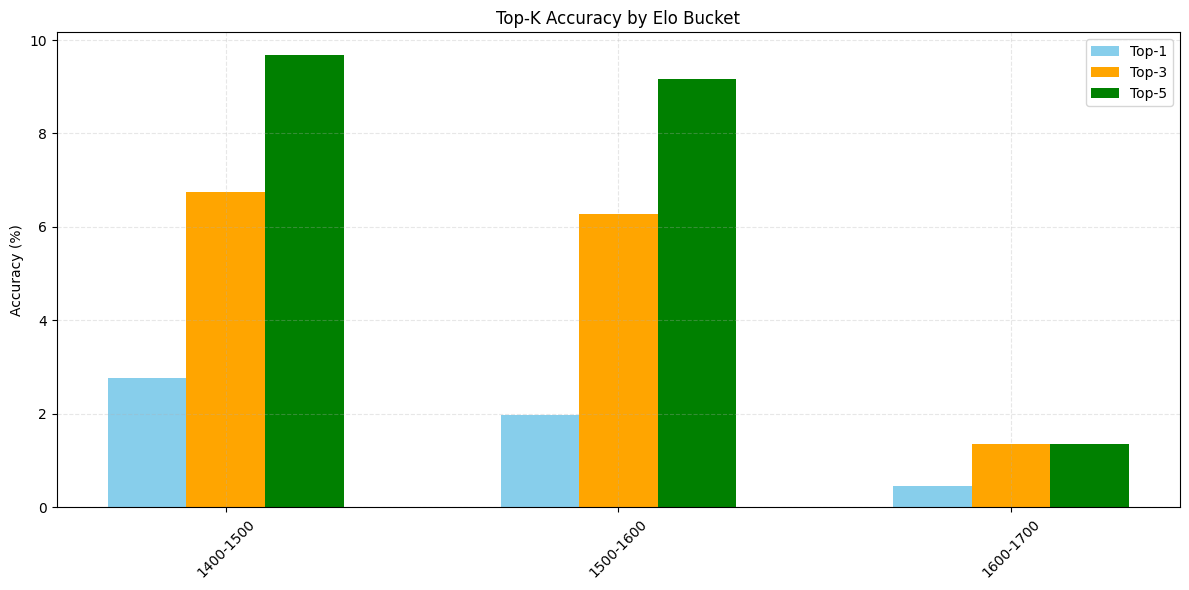

In [ ]:
def evaluate_topk_by_bucket(df, uci_to_idx, model_class, elo_ranges, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    topk_results = {"bucket": [], "top1": [], "top3": [], "top5": []}

    for elo_min, elo_max in elo_ranges:
        path = f"maia_finetuned_elo_{elo_min}_{elo_max}.pth"
        if not os.path.exists(path):
            print(f"⚠️ Skipping {elo_min}-{elo_max} (model not found)")
            continue

        # Load model
        model = model_class(num_classes=len(uci_to_idx)).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()

        # Filter data
        bucket_df = df[
            (df["white_elo"].between(elo_min, elo_max)) &
            (df["black_elo"].between(elo_min, elo_max)) &
            (df["move"].isin(uci_to_idx))
        ].reset_index(drop=True)

        if len(bucket_df) == 0:
            continue

        # Dataset
        class EvalDataset(Dataset):
            def __init__(self, df): self.df = df
            def __len__(self): return len(self.df)
            def __getitem__(self, idx):
                row = self.df.iloc[idx]
                return (
                    fen_to_tensor(row.fen),
                    torch.tensor([row.white_elo / 3000, row.black_elo / 3000], dtype=torch.float32),
                    uci_to_idx[row.move]
                )

        loader = DataLoader(EvalDataset(bucket_df), batch_size=batch_size)

        # Evaluate
        top1, top3, top5, total = 0, 0, 0, 0
        for board_tensor, elo_tensor, move_index in loader:
            board_tensor, elo_tensor, move_index = board_tensor.to(device), elo_tensor.to(device), move_index.to(device)
            out = model(board_tensor, elo_tensor)
            total += len(board_tensor)

            top1 += (out.topk(1, dim=1).indices == move_index.view(-1, 1)).any(dim=1).float().sum().item()
            top3 += (out.topk(3, dim=1).indices == move_index.view(-1, 1)).any(dim=1).float().sum().item()
            top5 += (out.topk(5, dim=1).indices == move_index.view(-1, 1)).any(dim=1).float().sum().item()

        topk_results["bucket"].append(f"{elo_min}-{elo_max}")
        topk_results["top1"].append(100 * top1 / total)
        topk_results["top3"].append(100 * top3 / total)
        topk_results["top5"].append(100 * top5 / total)

    return topk_results
def plot_topk_accuracies(results):
    import matplotlib.pyplot as plt

    buckets = results["bucket"]
    top1 = results["top1"]
    top3 = results["top3"]
    top5 = results["top5"]
    x = range(len(buckets))

    plt.figure(figsize=(12, 6))
    plt.bar([i - 0.2 for i in x], top1, width=0.2, label="Top-1", color="skyblue")
    plt.bar(x, top3, width=0.2, label="Top-3", color="orange")
    plt.bar([i + 0.2 for i in x], top5, width=0.2, label="Top-5", color="green")
    plt.xticks(x, buckets, rotation=45)
    plt.ylabel("Accuracy (%)")
    plt.title("Top-K Accuracy by Elo Bucket")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()
results = evaluate_topk_by_bucket(df, uci_to_idx, MaiaCNN, elo_ranges)
plot_topk_accuracies(results)


## 🔁 MaiaTransformer: Transformer-Based Human Move Predictor

This architecture reimagines the Maia CNN as a **Transformer-based model**, enabling it to better capture spatial dependencies and higher-order structure in chess positions. The design leverages the strengths of self-attention to understand long-range interactions between pieces on the board.

---

### 🧱 Architecture Overview

| Component               | Description |
|------------------------|-------------|
| **Board Embedding**    | A `Conv2d` layer maps the 12-channel board tensor (one plane per piece type) to a `d_model` dimensional space. Output shape becomes `[B, d_model, 8, 8]`. |
| **Flattening**         | Converts spatial features into a sequence: `[B, 64, d_model]` (64 board squares). |
| **CLS Token**          | A learned token prepended to the input sequence, used to aggregate global information for classification. |
| **Positional Encoding**| A learnable `nn.Parameter` added to encode spatial structure, allowing the transformer to distinguish between squares. |
| **Transformer Encoder**| A standard multi-layer `nn.TransformerEncoder` processes the input sequence, capturing square-level interactions via self-attention. |
| **Classification Head**| Applies `LayerNorm` + `Linear` projection to the output of the `[CLS]` token to generate logits over 4672 move classes. |

---

### 📌 Input/Output Shapes

- **Input**: `board_tensor` → `[B, 12, 8, 8]`
- **Intermediate**: Transformed to `[B, 65, d_model]` including `[CLS]` token
- **Output**: Final prediction logits → `[B, 4672]` (UCI move index vocabulary)

---

### 🎯 Why Transformers?

Transformers allow the model to:
- Capture **global board dynamics** better than local convolutions
- Learn **interactions between distant pieces** (e.g., queen and king across the board)
- Offer flexibility to scale to larger input embeddings or include temporal game context (future extension)

> This model variant is experimental and aligns with recent trends in vision-based Transformers (e.g., ViT), adapted here for structured chess input.

In [ ]:
class MaiaTransformer(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_layers=6, num_classes=4672, dropout=0.1):
        super().__init__()

        # === Board Embedding ===
        self.board_embed = nn.Conv2d(12, d_model, kernel_size=3, padding=1)  # [B, d_model, 8, 8]
        self.flatten = nn.Flatten(2)  # -> [B, d_model, 64]
        self.transpose = lambda x: x.transpose(1, 2)  # -> [B, 64, d_model]

        # === Positional Encoding ===
        self.positional_encoding = nn.Parameter(torch.randn(65, d_model))  # not 64


        # === Transformer Encoder ===
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # === Final Classification ===
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, board_tensor):
        # Embed board to d_model dims
        x = self.board_embed(board_tensor)  # [B, d_model, 8, 8]
        x = self.flatten(x)  # [B, d_model, 64]
        x = self.transpose(x)  # [B, 64, d_model]

        # Add cls token and positional encoding
        B = x.size(0)
        cls = self.cls_token.expand(B, -1, -1)  # [B, 1, d_model]
        x = torch.cat([cls, x], dim=1)  # [B, 65, d_model]
        x = x + self.positional_encoding.unsqueeze(0).expand(B, -1, -1)[:, :x.size(1), :]

        # Transformer
        x = self.transformer(x)  # [B, 65, d_model]
        cls_output = x[:, 0]  # [B, d_model]

        return self.head(cls_output)  # [B, num_classes]

## 🔁 Training & Evaluation: MaiaTransformer (Board-Only Input)

This block trains the **MaiaTransformer**, a ViT-style transformer architecture for human move prediction in chess, using only the board state as input (Elo information is excluded here).

---

### ⚙️ Configuration

| Parameter       | Value            |
|----------------|------------------|
| Model           | `MaiaTransformer` (6 layers, 8 heads, d_model=512) |
| Input           | FEN-encoded board → 12×8×8 tensor |
| Output classes  | 4672 UCI move indices |
| Batch Size      | 64               |
| Epochs          | 2                |
| Learning Rate   | 0.0005           |
| Loss Function   | CrossEntropyLoss |
| Optimizer       | Adam             |
| Evaluation      | Top-1, Top-3, Top-5 Accuracy |

### 🎯 Interpretation

These results reflect expected early performance from a transformer-based model trained **from scratch** on a small dataset:

- Transformers typically require **large datasets** and **longer training schedules** to converge due to their high capacity and lack of inductive biases.
- The model has not yet learned meaningful representations of board structure, which is evident from the relatively flat accuracy growth.

> ⚠️ Unlike CNNs, transformers do not hard-code spatial locality — this makes them more powerful in theory, but also more data-hungry.

---

### 💾 Output

The trained model is saved to disk as: maia_transformer.pth



In [ ]:
# === Top-k Accuracy Helper ===
def top_k_accuracy(outputs, targets, k=5):
    _, topk_preds = torch.topk(outputs, k, dim=1)
    matches = topk_preds.eq(targets.view(-1, 1))
    return matches.any(dim=1).float().mean().item()

# === Config ===
BATCH_SIZE = 64
EPOCHS = 2
LR = 0.0005
NUM_CLASSES = 4672

# === Dataset & Split ===

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# === Model, Loss, Optimizer ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaiaTransformer(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# === Training + Validation Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for board_tensor, _, move_index in train_loader:  # discard elo_tensor
        board_tensor, move_index = board_tensor.to(device), move_index.to(device)
        optimizer.zero_grad()
        outputs = model(board_tensor)
        loss = criterion(outputs, move_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    top1_correct = 0
    top3_acc = 0
    top5_acc = 0
    total = 0

    with torch.no_grad():
        for board_tensor, _, move_index in val_loader:
            board_tensor, move_index = board_tensor.to(device), move_index.to(device)
            outputs = model(board_tensor)
            _, preds = torch.max(outputs, 1)
            top1_correct += (preds == move_index).sum().item()
            top3_acc += top_k_accuracy(outputs, move_index, k=3) * move_index.size(0)
            top5_acc += top_k_accuracy(outputs, move_index, k=5) * move_index.size(0)
            total += move_index.size(0)

    top1 = top1_correct / total
    top3 = top3_acc / total
    top5 = top5_acc / total

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")
    print(f"Top-1 Acc: {top1*100:.2f}% | Top-3 Acc: {top3*100:.2f}% | Top-5 Acc: {top5*100:.2f}%")

# === Save model ===
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "maia_transformer.pth")

print("✅ Model saved to maia_transformer.pth")

Epoch 1/5 - Loss: 6.8677
Top-1 Acc: 1.08% | Top-3 Acc: 3.15% | Top-5 Acc: 5.56%
Epoch 2/5 - Loss: 6.6284
Top-1 Acc: 1.66% | Top-3 Acc: 4.42% | Top-5 Acc: 6.64%
